## Notebook to create a regional rainfall-runoff model using an LSTM network for CAMELS CH Dataset

*Transformer architecture from scratch;*
*Only 229 catchments belonging to CH from CAMELS CH*

**Description**

The following notebook contains the code to create, train, validate and test a rainfall-runoff model using a LSTM 
network architecture. The code allows for the creation of single-basin models, but it is conceptualized to create 
regional models. The code is intended as an intial introduction to the topic, in which we prioritized interpretability
over modularity. The model generated in this code makes use of the CAMELS CH Datset [2]

The logic of the code is heavily based on [Neural Hydrology](https://doi.org/10.21105/joss.04050)[1]. For a more 
flexible, robust and modular implementation of deep learning method in hydrological modeling we advice the use of Neural 
Hydrology. 

**Authors:**
- Eduardo Acuna Espinoza (eduardo.espinoza@kit.edu)
- Ralf Loritz
- Manuel Álvarez Chaves

**Adaptations:**
- Sanika Baste (sanika.baste@kit.edu)

**References:**

[1]: "F. Kratzert, M. Gauch, G. Nearing and D. Klotz: NeuralHydrology -- A Python library for Deep Learning research in hydrology. Journal of Open Source Software, 7, 4050, doi: 10.21105/joss.04050, 2022"

[2]: Höge, M., Kauzlaric, M., Siber, R., Schönenberger, U., Horton, P., Schwanbeck, J., Floriancic, M. G., Viviroli, D., Wilhelm, S., Sikorska-Senoner, A. E., Addor, N., Brunner, M., Pool, S., Zappa, M., and Fenicia, F.: CAMELS-CH: hydro-meteorological time series and landscape attributes for 331 catchments in hydrologic Switzerland, Earth Syst. Sci. Data, 15, 5755–5784, https://doi.org/10.5194/essd-15-5755-2023, 2023.

In [2]:
#Import necessary packages
import sys
import pandas as pd
import numpy as np
import time
import pickle
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

sys.path.append("../aux_functions")
sys.path.append("../datasetzoo")
sys.path.append("../modelzoo")

# Import classes and functions from other files
from functions_training import nse_basin_averaged
from functions_evaluation import nse
from functions_aux import create_folder, set_random_seed, write_report

# Import dataset to use
from camelsch_transformer import CAMELS_CH_Transformer as CAMELS_CH

# Import model
# from customlstm_original_softplus import customLSTM

# ignoring warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Part 1. Initialize information

In [3]:
# Define experiment name
experiment_name = "CAMELS_CH_transformers_fromscratch_229CH"

# paths to access the information
path_entities = "../../data/basin_id/basins_camels_ch_229_onlyCH.txt"
path_data = "../../data/CAMELS_CH"

# dynamic forcings and target
dynamic_input = ['precipitation(mm/d)', 'temperature_min(degC)', 'temperature_max(degC)', 'rel_sun_dur(%)', 'swe(mm)']
target = ['discharge_spec(mm/d)']

# static attributes that will be used
static_input = ['area',
                'elev_mean',
                'slope_mean',
                'sand_perc',
                'silt_perc',
                'clay_perc',
                'porosity',
                'conductivity',
                'glac_area',
                'dwood_perc',
                'ewood_perc',
                'crop_perc',
                'urban_perc',
                'reservoir_cap',
                'p_mean',
                'pet_mean',
                'p_seasonality',
                'frac_snow',
                'high_prec_freq',
                'low_prec_freq',
                'high_prec_dur',
                'low_prec_dur']

# time periods
training_period = ['1995-10-01','2005-09-30']
validation_period = ['2005-10-01','2010-09-30']
testing_period = ['2010-10-01','2015-09-30']

model_hyper_parameters = {
    "input_size_lstm": len(dynamic_input) + len(static_input),  
    "seq_length": 365,
    "hidden_size": 64,
    "batch_size_training":256,
    "batch_size_validation":512,
    "batch_size_testing":(pd.to_datetime(testing_period[1])-pd.to_datetime(testing_period[0])).days+1,
    "no_of_epochs": 75,             
    "drop_out_rate": 0.4, 
    "learning_rate": 0.001,
    "adapt_learning_rate_epoch": 25,
    "adapt_gamma_learning_rate": 0.5,
    "set_forget_gate":3,
    "validate_every": 1,
    "validate_n_random_basins": -1
    }

embedding_params = {"dynamic_inputs": dynamic_input,
                    "static_attributes": static_input,
                    "targets": target,
                    "dynamic_embedding_spec_encoder": {"type": "fc",
                                    "hiddens":[32] ,
                                    "activation": "linear",
                                    "dropout": 0.0},
                    "static_embedding_spec_encoder": {"type": "fc",
                                    "hiddens":[32],
                                    "activation": "linear",
                                    "dropout": 0.0},
                    "embedding_type": 'full_model'
                    }

transformer_hyperparameters = {
                                "n_inputfeatures":27, 
                                "n_predictions":1, 
                                "d_model":64, 
                                "d_ff":32,
                                "num_layers":1, 
                                "num_heads":4,
                                "device":f'cuda:0',
                                "src_pad_idx":None, 
                                "trg_pad_idx":None,
                                "dropout":0.4, 
                                "efficient_mha":True,
                                "embedding_params":embedding_params,
                                }

# device to train the model
running_device = "gpu" #cpu or gpu

# define random seed
seed = 17

# colorblind friendly palette for plotting
color_palette = {"observed": "#1f78b4","simulated": "#ff7f00"}

In [4]:
# Create folder to store the results
path_save_folder = "../results/"+experiment_name
create_folder(folder_path=path_save_folder)

Folder '../results/CAMELS_CH_transformers_fromscratch_229CH' already exists.


In [5]:
# check if model will be run in gpu or cpu and define device
if running_device == "gpu":
    print(torch.cuda.get_device_name(0))
    device = f'cuda:0'
elif running_device == "cpu":
    device = "cpu"

Tesla V100-SXM2-32GB


Part 2. Create dataset and dataloader for training

In [5]:
# Dataset training
training_dataset = CAMELS_CH(dynamic_input= dynamic_input,
                             target= target, 
                             sequence_length= model_hyper_parameters["seq_length"],
                             time_period= training_period,
                             path_data= path_data,
                             path_entities= path_entities,
                             static_input= static_input,
                             check_NaN= True)

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics(path_save_scaler=path_save_folder)
training_dataset.standardize_data()

In [6]:
# Dataloader training
train_loader = DataLoader(dataset = training_dataset, 
                          batch_size = model_hyper_parameters["batch_size_training"],
                          shuffle = True,
                          drop_last = True)

print("Batches in training: ", len(train_loader))
sample = next(iter(train_loader))
print(f'x_lstm: {sample["x_lstm"].shape} | y_obs: {sample["y_obs"].shape} | basin_std: {sample["basin_std"].shape}')

Batches in training:  1382
x_lstm: torch.Size([256, 365, 27]) | y_obs: torch.Size([256, 1, 1]) | basin_std: torch.Size([256, 1, 1])


Part 3. Create dataset for validation

In [7]:
# We will create an individual dataset per basin. This will give us more flexibility
entities_ids = np.loadtxt(path_entities, dtype="str").tolist()
validation_dataset = {}

for entity in entities_ids:
    dataset = CAMELS_CH(dynamic_input= dynamic_input,
                        target= target, 
                        sequence_length= model_hyper_parameters["seq_length"],
                        time_period= validation_period,
                        path_data= path_data,
                        entity= entity,
                        static_input= static_input,
                        check_NaN= False)
    
    dataset.scaler = training_dataset.scaler
    dataset.standardize_data(standardize_output=False)
    validation_dataset[entity]= dataset

Part 4.0. Vanilla Transformer (https://doi.org/10.1016/j.jhydrol.2024.131389)

In [7]:
### Residual Norm Layer ###

class ResidualLayerNorm(nn.Module):
    def __init__(self, d_model, dropout=0.5):
        super().__init__()
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, residual):
        # In the video this was:
        #   ln = self.layer_norm(x + residual)
        #   return self.dropout(ln)
        # The above does not lead to convergence. We must dropout x for convergence.
        # Why doesn't this work? Because we send the output of the layernorm to an attention block.
        # So some values would be zeroed out if dropout is enabled. Obviously MHA doesn't know what to attend to then.
        # We can dropout(x) though because 1) we're adding a residual to it, so dropped out values won't be zero
        # and 2), the layernorm has an additive beta parameter which provides a non-zero value to a tensor
        ln = self.layer_norm(self.dropout(x) + residual)
        return ln

In [8]:
### Positionwise Feed Forward neural Network ###

class PWFFN(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.5):
        super().__init__()

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        # shape(x) = [B x seq_len x d_model]

        ff = self.ff(x)
        # shape(ff) = [B x seq_len x d_model]

        return ff

In [9]:
### neural hydrology embedding class: Fully Connect Layer Definition ###
from typing import List

class FC(nn.Module):
    """Auxiliary class to build (multi-layer) fully-connected networks.

    This class is used to build fully-connected embedding networks for static and/or dynamic input data.
    Use the config argument `statics/dynamics_embedding` to specify the architecture of the embedding network. See the
    `InputLayer` class on how to specify the exact embedding architecture.

    Parameters
    ----------
    input_size : int
        Number of input features.
    hidden_sizes : List[int]
        Size of the hidden and output layers.
    activation : str, optional
        Activation function for intermediate layers, default tanh.
    dropout : float, optional
        Dropout rate in intermediate layers.
    """

    def __init__(self, input_size: int, hidden_sizes: List[int], activation: str = 'tanh', dropout: float = 0.0):
        super(FC, self).__init__()

        if len(hidden_sizes) == 0:
            raise ValueError('hidden_sizes must at least have one entry to create a fully-connected net.')

        self.output_size = hidden_sizes[-1]
        hidden_sizes = hidden_sizes[:-1]

        activation = self._get_activation(activation)

        # create network
        layers = []
        if hidden_sizes:
            for i, hidden_size in enumerate(hidden_sizes):
                if i == 0:
                    layers.append(nn.Linear(input_size, hidden_size))
                else:
                    layers.append(nn.Linear(hidden_sizes[i - 1], hidden_size))

                layers.append(activation)
                layers.append(nn.Dropout(p=dropout))

            layers.append(nn.Linear(hidden_size, self.output_size))
        else:
            layers.append(nn.Linear(input_size, self.output_size))

        self.net = nn.Sequential(*layers)
        self._reset_parameters()

    def _get_activation(self, name: str) -> nn.Module:
        if name.lower() == "tanh":
            activation = nn.Tanh()
        elif name.lower() == "sigmoid":
            activation = nn.Sigmoid()
        elif name.lower() == "relu":
            activation = nn.ReLU()
        elif name.lower() == "linear":
            activation = nn.Identity()
        else:
            raise NotImplementedError(f"{name} currently not supported as activation in this class")
        return activation

    def _reset_parameters(self):
        """Special initialization of certain model weights."""
        for layer in self.net:
            if isinstance(layer, nn.modules.linear.Linear):
                n_in = layer.weight.shape[1]
                gain = np.sqrt(3 / n_in)
                nn.init.uniform_(layer.weight, -gain, gain)
                nn.init.constant_(layer.bias, val=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Perform a forward pass on the FC model.

        Parameters
        ----------
        x : torch.Tensor
            Input data of shape [any, any, input size]

        Returns
        -------
        torch.Tensor
            Embedded inputs of shape [any, any, output_size], where 'output_size' is the size of the last network layer.
        """
        return self.net(x)

In [10]:
### Embeddings_nh ###

import logging
from typing import Dict, Optional, Union, Tuple

LOGGER = logging.getLogger(__name__)

_EMBEDDING_TYPES = ['full_model', 'hindcast', 'forecast']

class Embeddings_nh(nn.Module):
    """Input layer to preprocess static and dynamic inputs.

    This module provides optional embedding of dynamic and static inputs. If ``dynamic_embeddings`` or
    ``static_embeddings`` are specified as dictionaries in the config, a fully-connected embedding network will be
    prepended to the timeseries model. The dictionaries have the following keys:

    - ``type`` (default 'fc'): Type of the embedding net. Currently, only 'fc' for fully-connected net is supported.
    - ``hiddens``: List of integers that define the number of neurons per layer in the fully connected network.
      The last number is the number of output neurons. Must have at least length one.
    - ``activation`` (default 'tanh'): activation function of the network. Supported values are 'tanh', 'sigmoid',
      'linear'. The activation function is not applied to the output neurons, which always have a linear activation
      function. An activation function for the output neurons has to be applied in the main model class.
    - ``dropout`` (default 0.0): Dropout rate applied to the embedding network.

    Note that this module does not support multi-frequency runs.

    Parameters
    ----------
    cfg : Config
        The run configuration
    """

    def __init__(self,
                    dynamic_inputs: List,
                    static_attributes: List,
                    targets: List,
                    dynamic_embedding_spec_encoder: Dict,
                    static_embedding_spec_encoder: Dict,
                    device,
                    embedding_type: str = 'full_model'
                    ):
        super(Embeddings_nh, self).__init__()

        self.device = device
        
        if embedding_type not in _EMBEDDING_TYPES:
            raise ValueError(
                f'Embedding type {embedding_type} is not recognized. '
                f'Must be one of: {_EMBEDDING_TYPES}.'
            )
        self.embedding_type = embedding_type
        # self.sub_embedding_type = sub_embedding_type
            
        if isinstance(dynamic_inputs, dict):
            frequencies = list(dynamic_inputs.keys())
            if len(frequencies) > 1:
                raise ValueError('InputLayer only supports single-frequency data')
            dynamics_input_size = len(dynamic_inputs[frequencies[0]])
        else:
            dynamics_input_size_encoder = len(dynamic_inputs)
            # dynamics_input_size_decoder = len(targets)

        self._num_autoregression_inputs = 0

        statics_input_size = len(static_attributes)

        self.statics_embedding, self.statics_output_size = \
            self._get_embedding_net(embedding_spec=static_embedding_spec_encoder, input_size=statics_input_size, purpose='statics')
        self.dynamics_embedding, self.dynamics_output_size = \
            self._get_embedding_net(embedding_spec=dynamic_embedding_spec_encoder, input_size=dynamics_input_size_encoder, purpose='dynamics')
        # self.dynamics_embedding_decoder, self.dynamics_output_size_decoder = \
        #     self._get_embedding_net(embedding_spec=dynamic_embedding_spec_decoder, input_size=dynamics_input_size_decoder, purpose='dynamics_decoder')

        self.statics_embedding_p_dropout = 0.0  # if net has no statics dropout we treat is as zero
        self.dynamics_embedding_p_dropout = 0.0  # if net has no dynamics dropout we treat is as zero

        # if sub_embedding_type == 'encoder':
        #     self.output_size = self.dynamics_output_size + self.statics_output_size + self._num_autoregression_inputs
        # else:
        #     self.output_size = self.dynamics_output_size_decoder

    @staticmethod
    def _get_embedding_net(embedding_spec: Optional[dict], input_size: int, purpose: str) -> Tuple[nn.Module, int]:
        """Get an embedding net following the passed specifications.

        If the `embedding_spec` is None, the returned embedding net will be the identity function.

        Parameters
        ----------
        embedding_spec : Optional[dict]
            Specification of the embedding net from the run configuration or None.
        input_size : int
            Size of the inputs into the embedding network.
        purpose : str
            Purpose of the embedding network, used for error messages.

        Returns
        -------
        Tuple[nn.Module, int]
            The embedding net and its output size.
        """
        if embedding_spec is None:
            return nn.Identity(), input_size

        if input_size == 0:
            raise ValueError(f'Cannot create {purpose} embedding layer with input size 0')

        emb_type = embedding_spec['type'].lower()
        if emb_type != 'fc':
            raise ValueError(f'{purpose} embedding type {emb_type} not supported.')

        hiddens = embedding_spec['hiddens']
        if len(hiddens) == 0:
            raise ValueError(f'{purpose} embedding "hiddens" must be a list of hidden sizes with at least one entry')

        dropout = embedding_spec['dropout']
        activation = embedding_spec['activation']

        emb_net = FC(input_size=input_size, hidden_sizes=hiddens, activation=activation, dropout=dropout)
        return emb_net, emb_net.output_size

    def forward(self, data: Dict[str, torch.Tensor], concatenate_output: bool = True) \
            -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Perform a forward pass on the input layer.

        Parameters
        ----------
        data : Dict[str, torch.Tensor]
            The input data.
        concatenate_output : bool, optional
            If True (default), the forward method will concatenate the static inputs to each dynamic time step.
            If False, the forward method will return a tuple of (dynamic, static) inputs.

        Returns
        -------
        Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]
            If `concatenate_output` is True, a single tensor is returned. Else, a tuple with one tensor of dynamic
            inputs and one tensor of static inputs.
        """
        # do not transpose to [seq_length, batch_size, n_features]
        if self.embedding_type == 'full_model':
            data_type_encoder = 'x_d'
            # data_type_decoder = 'y_obs'
        elif self.embedding_type == 'forecast':
            data_type = 'x_f'
        elif self.embedding_type == 'hindcast':
            data_type = 'x_h'
        x_d = data[data_type_encoder].transpose(0, 1).to(self.device)
        # shape(x_d) = [B, seq_length, n_inputfeatures]
        # y_obs = data[data_type_decoder].transpose(0, 1).to(self.device)

        if 'x_s' in data and 'x_one_hot' in data:
            x_s = torch.cat([data['x_s'], data['x_one_hot']], dim=-1)
        elif 'x_s' in data:
            x_s = data['x_s'].to(self.device)
        elif 'x_one_hot' in data:
            x_s = data['x_one_hot']
        else:
            x_s = data['x_lstm'][:, 1, -22:]

        # Don't run autoregressive inputs through the embedding layer. This does not work with NaN's
        if self._num_autoregression_inputs > 0:
            dynamics_out = self.dynamics_embedding(x_d[:, :, :-self._num_autoregression_inputs])
        else:
            dynamics_out_encoder = self.dynamics_embedding(x_d)
            # dynamics_out_decoder = self.dynamics_embedding_decoder(y_obs)

        statics_out = None
        if x_s is not None:
            statics_out = self.statics_embedding(x_s)

        # if self.sub_embedding_type == 'encoder':
        if not concatenate_output:
            ret_val = dynamics_out, statics_out
        else:
            if statics_out is not None:
                statics_out = statics_out.unsqueeze(0).repeat(dynamics_out_encoder.shape[0], 1, 1)
                ret_val = torch.cat([dynamics_out_encoder, statics_out], dim=-1)
            else:
                ret_val = dynamics_out_encoder
            
            # Append autoregressive inputs to the end of the output.
            if self._num_autoregression_inputs:
                ret_val = torch.cat([ret_val, x_d[:, :, -self._num_autoregression_inputs:]], dim=-1)
        # elif self.sub_embedding_type == 'decoder':
        #     ret_val = dynamics_out_decoder      

        return ret_val.transpose(0, 1)

    def __getitem__(self, item: str) -> nn.Module:
        # required for dict-like access when freezing submodules' gradients in fine-tuning
        if item == "statics_embedding":
            return self.statics_embedding
        elif item == "dynamics_embedding":
            return self.dynamics_embedding
        else:
            raise KeyError(f"Cannot access {item} on InputLayer")

In [11]:
### Positional and Time Learnable Encoding ###

class PositionalAndTimeEncoding(nn.Module):
    def __init__(self, d_model, device, dropout=0.5, max_seq_len=1000, N_i = 365):
        super().__init__()
        self.d_model = d_model
        self.linear_pe = nn.Linear(d_model, d_model)
        self.linear_te = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

        # positional encoding
        pe = torch.zeros(max_seq_len, d_model).to(device)
        pos = torch.arange(0, max_seq_len).unsqueeze(1).float()
        two_i = torch.arange(0, d_model, step=2).float()
        div_term = torch.pow(10000, (two_i/torch.Tensor([d_model]))).float()
        pe[:, 0::2] = torch.sin(pos/div_term)
        pe[:, 1::2] = torch.cos(pos/div_term)
        pe = pe.unsqueeze(0)
        # shape(pe) = [1 x max_seq_len x d_model]
        # assigns the first argument to a class variable
        # i.e. self.pe
        self.register_buffer("pe", pe)

        # time encoding
        te = torch.zeros(max_seq_len, d_model).to(device)
        pos = torch.arange(0, max_seq_len).unsqueeze(1).float()
        te[:, :] = pos/N_i - 0.5
        te = te.unsqueeze(0)
        # shape(pe) = [1 x max_seq_len x d_model]
        # assigns the first argument to a class variable
        # i.e. self.te
        self.register_buffer("te", te)

    def forward(self, x):
        # shape(x) = [B x seq_len x d_model]
        one_batch_pe: torch.Tensor = self.pe[:, :x.shape[1]].detach()
        # shape(one_batch_pe) = [1 x seq_len x d_model]
        repeated_pe = one_batch_pe.repeat([x.shape[0], 1, 1]).detach()
        # shape(repeated_pe) = [B x seq_len x d_model]
        learnable_pe = self.linear_pe(repeated_pe)
        # shape(learnable_pe) = [B x seq_len x d_model]

        one_batch_te: torch.Tensor = self.te[:, :x.shape[1]].detach()
        # shape(one_batch_te) = [1 x seq_len x d_model]
        repeated_te = one_batch_te.repeat([x.shape[0], 1, 1]).detach()
        # shape(repeated_te) = [B x seq_len x d_model]
        learnable_te = self.linear_te(repeated_te)
        # shape(learnable_te) = [B x seq_len x d_model]

        learnable_encoding = learnable_pe.add(learnable_te)
        x = x.add(learnable_encoding)
        # shape(x) = [B x seq_len x d_model]
        return x

In [12]:
### MultiHead Attention with Dropout on Weights for Q, K, V###

import math as m
import torch.nn.functional as F

class EfficientMultiHeadAttention_DO(nn.Module):
    def __init__(self, d_model=4, num_heads=2, dropout=0.5):
        super().__init__()

        # Q_len, KV_len
        self.d = d_model//num_heads

        self.d_model = d_model
        self.num_heads = num_heads

        self.dropout = nn.Dropout(dropout)

        # initialising Wq, Wk and Wv for calculation of Q, K and V as parameters
        # instead of nn.Linear, in order to be able to apply dropout
        self.WQ = nn.Parameter(torch.FloatTensor(d_model, d_model))
        self.WK = nn.Parameter(torch.FloatTensor(d_model, d_model))
        self.WV = nn.Parameter(torch.FloatTensor(d_model, d_model))

        self.mha_linear = nn.Linear(d_model, d_model)

        # Initialize parameters; because we have initialised nn.Parameter and not nn.Linear
        # self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.WQ)
        nn.init.xavier_uniform_(self.WK)
        nn.init.xavier_uniform_(self.WV)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # shape(Q) = [B x num_heads x Q_len x d_model/num_heads]
        # shape(K, V) = [B x num_heads x KV_len x d_model/num_heads]

        # reshaped(K) = [B x num_heads x d_model/num_heads x KV_len]
        Q_K_matmul = torch.matmul(Q, K.permute(0, 1, 3, 2))
        scores = Q_K_matmul/m.sqrt(self.d)
        # shape(scores) = [B x num_heads x Q_len x KV_len]

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)
        # shape(attention_weights) = [B x num_heads x Q_len x KV_len]

        output = torch.matmul(attention_weights, V)
        # shape(V) = [B x num_heads x KV_len x d_model/num_heads]
        # shape(output) = [B x num_heads x Q_len x d_model/num_heads]

        return output, attention_weights

    def forward(self, pre_q, pre_k, pre_v, mask=None):
        # shape(pre_q) = shape(pre_k) = shape(pre_v) = [B x seq_len x d_model]
        # shape(self.WQ) = shape(self.WK) = shape(self.WV) = [d_model x d_model]

        # Q, K and V are going to be calculated by matrix multiplying the pre_q, pre_k
        # and pre_v with their respective learnable weights after applying dropout
        Q = torch.matmul(pre_q, self.dropout(self.WQ))
        K = torch.matmul(pre_k, self.dropout(self.WK))
        V = torch.matmul(pre_v, self.dropout(self.WV))
        # shape(Q) = [B x seq_len x d_model] (if in encoder, seq_len = SRC_seq_len; if in decoder, seq_len = TRG_seq_len)
        # shape(K, V) = [B x seq_len x d_model] (always SRC_seq_len unless in masked-multihead-attention)

        batch_size = pre_q.shape[0]

        Q = Q.reshape(batch_size, self.num_heads, -1, self.d)
        K = K.reshape(batch_size, self.num_heads, -1, self.d)
        V = V.reshape(batch_size, self.num_heads, -1, self.d)
        # shape(Q) = [B x num_heads x seq_len x d_model/num_heads]
        # shape(K, V) = [B x num_heads x seq_len x d_model/num_heads]

        # run scaled_dot_product_attention
        output, attn_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        # shape(output) = [B x num_heads x Q_len x d_model/num_heads]
        # shape(attn_weights) = [B x num_heads x Q_len x KV_len]

        output = output.reshape(batch_size, -1, self.d_model)
        # shape(output) = [B x seq_len x d_model]

        projection = self.dropout(self.mha_linear(output))

        return projection, attn_weights

In [13]:
### Encoder Layer and Encoder ###


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.5, efficient_mha=True):
        super().__init__()

        # initalize these
        self.norm_1 = ResidualLayerNorm(d_model, dropout)
        self.norm_2 = ResidualLayerNorm(d_model, dropout=0.0) # for final batch normalisation dropout is not implemented

        if efficient_mha:
            self.mha = EfficientMultiHeadAttention_DO(d_model, num_heads, dropout)
        else:
            self.mha = MultiHeadAttention(d_model, num_heads, dropout)

        self.ff = PWFFN(d_model, d_ff, dropout)

    def forward(self, x, mask):
        # shape(x) = [B x seq_len x d_model]

        mha, encoder_attention_weights = self.mha(x, x, x, mask)
        # shape(mha) = [B x seq_len x D]
        # shape(encoder_attention_weights) = [B x num_heads x seq_len x seq_len]

        norm1 = self.norm_1(mha, x)
        # shape(norm1) = [B x seq_len x D]

        ff = self.ff(norm1)
        norm2 = self.norm_2(ff, norm1)
        # shape(ff) = [B x seq_len x D]
        # shape(norm2) = [B x seq_len x D]

        return norm2, encoder_attention_weights

In [14]:
### Encoder ###

import torch
import torch.nn as nn
# from .encoder_layer import EncoderLayer
# from .positional_encoding import PositionalEncoding
# from .embed import Embeddings


class Encoder(nn.Module):
    def __init__(self, Embedding: Embeddings_nh,
                 d_model,
                 num_heads,
                 num_layers,
                 d_ff,
                 device,
                 dropout=0.5,
                 efficient_mha=True):
        super().__init__()

        self.embedding = Embedding

        self.LE = PositionalAndTimeEncoding(
            d_model, device)

        self.encoder_layers = nn.ModuleList([EncoderLayer(
            d_model,
            num_heads,
            d_ff,
            dropout,
            efficient_mha
        ) for layer in range(num_layers)])

    def forward(self, x, mask=None):
        # shape(x) = [B x SRC_seq_len]
        # x['x_d'] = x['x_d'].to(device)
        # x['x_s'] = x['x_s'].to(device)
        # x['y_obs'] = x['y_obs'].to(device)

        embeddings = self.embedding(x)
        encoding = self.LE(embeddings)
        # shape(embeddings) = [B x SRC_seq_len x D]
        # shape(learnable_encoding) = [B x SRC_seq_len x D]

        for encoder_layer in self.encoder_layers:
            encoding, encoder_attention_weights = encoder_layer(encoding, mask)
            # shape(encoding) = [B x SRC_seq_len x D]
            # shape(encoder_attention_weights) = [B x SRC_seq_len x SRC_seq_len]
            
        return encoding, encoder_attention_weights

In [15]:
### Transformers ###

class Transformer(nn.Module):
    def __init__(self,
                    n_inputfeatures:int,
                    n_predictions:int,
                    d_model:int,
                    d_ff:int,
                    num_layers:int,
                    num_heads:int,
                    embedding_params:dict,
                    device,
                    src_pad_idx=None,
                    trg_pad_idx=None,
                    dropout:float=0.5,
                    efficient_mha=True
                    ):
        super().__init__()

        self.num_heads = num_heads
        self.device = device
        self.efficient_mha = efficient_mha

        encoder_Embedding = Embeddings_nh(dynamic_inputs=embedding_params["dynamic_inputs"],
                    static_attributes=embedding_params["static_attributes"],
                    targets=embedding_params["targets"],
                    dynamic_embedding_spec_encoder=embedding_params["dynamic_embedding_spec_encoder"],
                    static_embedding_spec_encoder=embedding_params["static_embedding_spec_encoder"],
                    device=self.device,
                    embedding_type=embedding_params["embedding_type"])

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

        self.encoder = Encoder(encoder_Embedding, d_model,
                               num_heads, num_layers, d_ff, device, dropout, efficient_mha)
        # self.decoder = Decoder(decoder_Embedding, d_model,
        #                        num_heads, num_layers, d_ff, device, dropout, efficient_mha)

        self.transformer_linear = nn.Linear(d_model, n_predictions)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def create_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1)
        if self.efficient_mha:
            src_mask = src_mask.unsqueeze(2)
        return src_mask

    def create_trg_mask(self, trg):
        if self.efficient_mha:
            trg_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
            mask = torch.ones((1, self.num_heads, trg.shape[1], trg.shape[1])).triu(1).to(self.device)
        else:
            trg_mask = (trg != self.trg_pad_idx).unsqueeze(1)
            mask = torch.ones((1, trg.shape[1], trg.shape[1])).triu(1).to(self.device)
        mask = mask == 0
        trg_mask = trg_mask & mask
        return trg_mask

    def forward(self, src):
        # shape(src) = [B x SRC_seq_len x input_features]
        # shape(trg) = [B x TRG_seq_len x 1]

        # src_mask = self.create_src_mask(src)
        # trg_mask = self.create_trg_mask(trg)
        # shape(src_mask) = [B x 1 x SRC_seq_len]
        # shape(trg_mask) = [B x 1 x TRG_seq_len]

        encoder_outputs, encoder_mha_attn_weights = self.encoder(src, mask=None)
        # shape(encoder_outputs) = [B x SRC_seq_len x d_model]
        # shape(encoder_mha_attn_weights) = [B x num_heads x SRC_seq_len x SRC_seq_len]

        # decoder_outputs, _, enc_dec_mha_attn_weights = self.decoder(trg, encoder_outputs, trg_mask, src_mask=None)
        # shape(decoder_outputs) = [B x TRG_seq_len x d_model]
        # shape(enc_dec_mha_attn_weights) = [B x num_heads x TRG_seq_len x SRC_seq_len]

        output = self.transformer_linear(encoder_outputs)
        # shape(logits) = [B x TRG_seq_len x n_predictions]

        pred = {"encoder_outputs": encoder_outputs,
                    "encoder_mha_attn_weights": encoder_mha_attn_weights,
                    "output": output,
                    "y_hat": output[:, -1, :]}

        return pred

Trial

In [26]:
transformer_model = Transformer(n_inputfeatures=transformer_hyperparameters["n_inputfeatures"], 
                                n_predictions=transformer_hyperparameters["n_predictions"], 
                                d_model=transformer_hyperparameters["d_model"], 
                                d_ff=transformer_hyperparameters["d_ff"],
                                num_layers=transformer_hyperparameters["num_layers"], 
                                num_heads=transformer_hyperparameters["num_heads"], 
                                embedding_params=transformer_hyperparameters["embedding_params"],
                                device=transformer_hyperparameters["device"],
                                src_pad_idx=transformer_hyperparameters["src_pad_idx"], 
                                trg_pad_idx=transformer_hyperparameters["trg_pad_idx"],
                                dropout=transformer_hyperparameters["dropout"], 
                                efficient_mha=transformer_hyperparameters["efficient_mha"],
                                ).to(device)

In [27]:
print(transformer_model.parameters)

<bound method Module.parameters of Transformer(
  (encoder): Encoder(
    (embedding): Embeddings_nh(
      (statics_embedding): FC(
        (net): Sequential(
          (0): Linear(in_features=22, out_features=32, bias=True)
        )
      )
      (dynamics_embedding): FC(
        (net): Sequential(
          (0): Linear(in_features=5, out_features=32, bias=True)
        )
      )
    )
    (LE): PositionalAndTimeEncoding(
      (linear_pe): Linear(in_features=64, out_features=64, bias=True)
      (linear_te): Linear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder_layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (norm_1): ResidualLayerNorm(
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.5, inplace=False)
        )
        (norm_2): ResidualLayerNorm(
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout): Dro

In [28]:
print("Static Embedding Weights: ", transformer_model.encoder.embedding.statics_embedding.net[0].weight)
print("Dynamic Embedding Weights: ", transformer_model.encoder.embedding.dynamics_embedding.net[0].weight)
print("Learnambe PE Weights: ", transformer_model.encoder.LE.linear_pe.weight)
print("Learnambe TE Weights: ", transformer_model.encoder.LE.linear_te.weight)
print("WQ_encoderlayer0:, ", transformer_model.encoder.encoder_layers[0].mha.WQ)
print("WQ_encoderlayer1:, ", transformer_model.encoder.encoder_layers[1].mha.WQ)
print("WQ_encoderlayer2:, ", transformer_model.encoder.encoder_layers[2].mha.WQ)
print("WQ_encoderlayer3:, ", transformer_model.encoder.encoder_layers[3].mha.WQ)
print("WK_encoderlayer0:, ", transformer_model.encoder.encoder_layers[0].mha.WK)
print("WK_encoderlayer1:, ", transformer_model.encoder.encoder_layers[1].mha.WK)
print("WK_encoderlayer2:, ", transformer_model.encoder.encoder_layers[2].mha.WK)
print("WK_encoderlayer3:, ", transformer_model.encoder.encoder_layers[3].mha.WK)
print("WV_encoderlayer0:, ", transformer_model.encoder.encoder_layers[0].mha.WV)
print("WV_encoderlayer1:, ", transformer_model.encoder.encoder_layers[1].mha.WV)
print("WV_encoderlayer2:, ", transformer_model.encoder.encoder_layers[2].mha.WV)
print("WV_encoderlayer3:, ", transformer_model.encoder.encoder_layers[3].mha.WV)

Static Embedding Weights:  Parameter containing:
tensor([[ 1.2530e-01, -1.4016e-01,  1.7390e-01,  8.4837e-02,  2.7494e-01,
          3.3575e-02, -2.1334e-01, -1.1192e-01, -2.5468e-01,  3.8594e-02,
          3.2039e-01,  3.2929e-01,  3.2593e-01,  1.3571e-01, -1.4120e-01,
          1.4147e-01, -2.1515e-01, -1.7341e-01,  1.2889e-01, -9.8581e-02,
          1.6212e-01,  2.3664e-01],
        [ 2.9361e-01,  2.4858e-01,  5.3872e-02,  4.3967e-02, -1.2076e-01,
          1.6033e-01,  2.6528e-01, -1.5775e-01,  2.8396e-01, -1.6072e-01,
         -2.1416e-01, -7.1027e-02, -1.9892e-01, -7.3502e-02,  3.4988e-02,
         -2.9519e-01, -4.1451e-03, -2.5245e-01, -2.3054e-01, -2.0371e-01,
          9.4390e-02, -1.5040e-01],
        [ 2.8829e-01, -1.6070e-01,  3.0712e-01,  2.9678e-01,  9.5670e-02,
          2.9306e-01, -2.4112e-01, -1.6877e-01,  3.3217e-01, -1.5581e-01,
          1.6117e-01, -3.2037e-02,  2.7571e-01,  1.2421e-01,  1.8412e-01,
          2.1102e-01,  1.3560e-01,  2.0608e-01, -2.5009e-01, -1.1

In [29]:
sample = next(iter(train_loader))

# optimizer
optimizer = torch.optim.Adam(transformer_model.parameters(),
                             lr=model_hyper_parameters["learning_rate"])

In [31]:
optimizer.zero_grad() # sets gradients of weigths and bias to zero
output = transformer_model(sample)

loss = nse_basin_averaged(y_sim=output['y_hat'], 
                          y_obs=sample["y_obs"].to(device), 
                          per_basin_target_std=sample["basin_std"].to(device))

loss.backward() # backpropagates
optimizer.step() # update weights

In [78]:
print("Static Embedding Weights: ", transformer_model.encoder.embedding.statics_embedding.net[0].weight)
print("Dynamic Embedding Weights: ", transformer_model.encoder.embedding.dynamics_embedding.net[0].weight)
print("Learnambe PE Weights: ", transformer_model.encoder.LE.linear_pe.weight)
print("Learnambe TE Weights: ", transformer_model.encoder.LE.linear_te.weight)
print("WQ_encoderlayer0:, ", transformer_model.encoder.encoder_layers[0].mha.WQ)
print("WQ_encoderlayer1:, ", transformer_model.encoder.encoder_layers[1].mha.WQ)
print("WQ_encoderlayer2:, ", transformer_model.encoder.encoder_layers[2].mha.WQ)
print("WQ_encoderlayer3:, ", transformer_model.encoder.encoder_layers[3].mha.WQ)
print("WK_encoderlayer0:, ", transformer_model.encoder.encoder_layers[0].mha.WK)
print("WK_encoderlayer1:, ", transformer_model.encoder.encoder_layers[1].mha.WK)
print("WK_encoderlayer2:, ", transformer_model.encoder.encoder_layers[2].mha.WK)
print("WK_encoderlayer3:, ", transformer_model.encoder.encoder_layers[3].mha.WK)
print("WV_encoderlayer0:, ", transformer_model.encoder.encoder_layers[0].mha.WV)
print("WV_encoderlayer1:, ", transformer_model.encoder.encoder_layers[1].mha.WV)
print("WV_encoderlayer2:, ", transformer_model.encoder.encoder_layers[2].mha.WV)
print("WV_encoderlayer3:, ", transformer_model.encoder.encoder_layers[3].mha.WV)

Static Embedding Weights:  Parameter containing:
tensor([[ 0.1949, -0.0307, -0.1081, -0.0526,  0.1913, -0.1175, -0.1991,  0.0089,
         -0.1882, -0.1186,  0.3176,  0.3121, -0.1327, -0.2131,  0.2551, -0.3072,
          0.3107, -0.2513,  0.0225, -0.1053,  0.1174, -0.1195],
        [-0.0338, -0.2284,  0.2203, -0.0597, -0.0580,  0.1714,  0.2458,  0.1776,
          0.1546,  0.3172,  0.0962, -0.0875,  0.1314, -0.2656, -0.2779, -0.1971,
         -0.3231, -0.2810, -0.0744,  0.1012,  0.1102, -0.1447],
        [ 0.0083, -0.1441, -0.3169, -0.1206, -0.1830,  0.2259,  0.0436,  0.1186,
          0.1092, -0.0584, -0.0374,  0.2671, -0.1250,  0.2748, -0.1827, -0.1251,
          0.2222, -0.0839, -0.0440,  0.1201,  0.3044, -0.1051],
        [-0.0145,  0.2760, -0.0322, -0.2602, -0.1062,  0.1997, -0.1684,  0.2615,
         -0.3098,  0.0962, -0.1035, -0.2223, -0.0371, -0.0135, -0.0836, -0.0262,
          0.2280, -0.0500,  0.2136, -0.1840, -0.1239,  0.2885],
        [ 0.1965,  0.2839, -0.0931, -0.2425, -0

Part 4. Train LSTM

In [ ]:
#### construct model
set_random_seed(seed=seed)
transformer_model = Transformer(n_inputfeatures=transformer_hyperparameters["n_inputfeatures"], 
                                n_predictions=transformer_hyperparameters["n_predictions"], 
                                d_model=transformer_hyperparameters["d_model"], 
                                d_ff=transformer_hyperparameters["d_ff"],
                                num_layers=transformer_hyperparameters["num_layers"], 
                                num_heads=transformer_hyperparameters["num_heads"], 
                                embedding_params=transformer_hyperparameters["embedding_params"],
                                device=transformer_hyperparameters["device"],
                                src_pad_idx=transformer_hyperparameters["src_pad_idx"], 
                                trg_pad_idx=transformer_hyperparameters["trg_pad_idx"],
                                dropout=transformer_hyperparameters["dropout"], 
                                efficient_mha=transformer_hyperparameters["efficient_mha"],
                                ).to(device)

# in case of training a previously trained model further
# path_pretrained = "../results/LSTM_CAMELS_CH_transformers_we_229CH"
# transformer_model.load_state_dict(torch.load(path_pretrained + "/epoch_21", map_location=device))

# optimizer
optimizer = torch.optim.Adam(transformer_model.parameters(),
                             lr=model_hyper_parameters["learning_rate"])
    
# define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=model_hyper_parameters["adapt_learning_rate_epoch"],
                                            gamma=model_hyper_parameters["adapt_gamma_learning_rate"])

# set forget gate to 3 to ensure that the model is capable to learn long term dependencies
# lstm_model.cell.b_hh.data[model_hyper_parameters["hidden_size"]:2 * model_hyper_parameters["hidden_size"]]=\
#     model_hyper_parameters["set_forget_gate"]

training_time = time.time()
# Loop through the different epochs
for epoch in range(1, model_hyper_parameters["no_of_epochs"]+1):
    
    epoch_start_time = time.time()
    total_loss = []
    # Training -------------------------------------------------------------------------------------------------------
    transformer_model.train()
    for sample in train_loader: 
        optimizer.zero_grad() # sets gradients of weigths and bias to zero
        pred  = transformer_model(sample) # forward call
        
        loss = nse_basin_averaged(y_sim=pred["y_hat"], 
                                  y_obs=sample["y_obs"].to(device), 
                                  per_basin_target_std=sample["basin_std"].to(device))
        
        loss.backward() # backpropagates
        # torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), 1) #clip gradients
        optimizer.step() # update weights
        total_loss.append(loss.item())
        
        # remove from cuda
        del sample["x_lstm"], sample["y_obs"], sample["basin_std"], pred
        torch.cuda.empty_cache()
        
    #training report  
    report = f'Epoch: {epoch:<2} | Loss training: {"%.3f "% (np.mean(total_loss))}'
    
    # Validation -----------------------------------------------------------------------------------------------------
    if epoch % model_hyper_parameters["validate_every"] == 0:
        transformer_model.eval()
        validation_results = {}
        with torch.no_grad():
            # If we define validate_n_random_basins as 0 or negative, we take all the basins
            if model_hyper_parameters["validate_n_random_basins"] <= 0:
                validation_basin_ids = validation_dataset.keys()
            else:
                keys = list(validation_dataset.keys())
                validation_basin_ids = random.sample(keys, model_hyper_parameters["validate_n_random_basins"])
            
            # go through each basin that will be used for validation
            for basin in validation_basin_ids:
                loader = DataLoader(dataset=validation_dataset[basin], 
                                    batch_size=model_hyper_parameters["batch_size_validation"], 
                                    shuffle=False, 
                                    drop_last = False)
                
                df_ts = pd.DataFrame()
                for sample in loader:
                    pred  = transformer_model(sample)
                    # backtransformed information
                    y_sim = pred["y_hat"]* validation_dataset[basin].scaler["y_std"].to(device) +\
                        validation_dataset[basin].scaler["y_mean"].to(device)

                    # join results in a dataframe and store them in a dictionary (is easier to plot later)
                    df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                                       "y_sim": y_sim.flatten().cpu().detach()}, 
                                      index=pd.to_datetime(sample["date"]))

                    df_ts = pd.concat([df_ts, df], axis=0)

                    # remove from cuda
                    del pred, y_sim
                    torch.cuda.empty_cache()       
                
                validation_results[basin] = df_ts
                 
            #average loss validation
            loss_validation = nse(df_results=validation_results)
            report += f'| NSE validation: {"%.3f "% (loss_validation)}'

    
    # save model after every epoch
    path_saved_model = path_save_folder+"/epoch_" + str(epoch)
    torch.save(transformer_model.state_dict(), path_saved_model)
            
    # print epoch report
    report += f'| Epoch time: {"%.1f "% (time.time()-epoch_start_time)} s | LR:{"%.5f "% (optimizer.param_groups[0]["lr"])}'
    print(report)
    write_report(file_path=path_save_folder+"/run_progress.txt", text=report)
    # modify learning rate
    scheduler.step()

# print final report
report = f'Total training time: {"%.1f "% (time.time()-training_time)} s'
print(report)
write_report(file_path=path_save_folder+"/run_progress.txt", text=report)   

Part 5. Test LSTM

In [16]:
# In case I already trained an LSTM I can re-construct the model
transformer_model = Transformer(n_inputfeatures=transformer_hyperparameters["n_inputfeatures"], 
                                n_predictions=transformer_hyperparameters["n_predictions"], 
                                d_model=transformer_hyperparameters["d_model"], 
                                d_ff=transformer_hyperparameters["d_ff"],
                                num_layers=transformer_hyperparameters["num_layers"], 
                                num_heads=transformer_hyperparameters["num_heads"], 
                                embedding_params=transformer_hyperparameters["embedding_params"],
                                device=transformer_hyperparameters["device"],
                                src_pad_idx=transformer_hyperparameters["src_pad_idx"], 
                                trg_pad_idx=transformer_hyperparameters["trg_pad_idx"],
                                dropout=transformer_hyperparameters["dropout"], 
                                efficient_mha=transformer_hyperparameters["efficient_mha"],
                                ).to(device)
transformer_model.load_state_dict(torch.load(path_save_folder + "/epoch_59", map_location=device))

<All keys matched successfully>

In [29]:
# We will create an individual dataset per basin. This will give us more flexibility
#path_entities = "../../data/basin_id/basins_camels_gb_lees.txt"
entities_ids = np.loadtxt(path_entities, dtype="str").tolist()
# entities_ids = ['2346', '2303', '2494']
testing_dataset = {}
seq_length = model_hyper_parameters["seq_length"]-1
idx_to_change = [512, 519]

# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)

for entity in entities_ids:
    dataset = CAMELS_CH(dynamic_input= dynamic_input,
                        target= target, 
                        sequence_length= model_hyper_parameters["seq_length"],
                        time_period= testing_period,
                        path_data= path_data,
                        entity= entity,
                        static_input= static_input,
                        check_NaN= False)

    # artificially adding 300 year return period rainfall for catchment 2109
    if entity == '2368':
        dataset.sequence_data[entity]['x_d'][seq_length+idx_to_change[0]:seq_length+idx_to_change[1], 0] = 1200
    
    dataset.scaler = scaler
    dataset.standardize_data(standardize_output=False)
    testing_dataset[entity]= dataset

In [30]:
transformer_model.eval()
inspect_results_states = {}
inspect_results = {}
create_folder(folder_path=path_save_folder+"/inspect_results_states")

with torch.no_grad():
    for basin, dataset in testing_dataset.items():
        loader = DataLoader(dataset = dataset, 
                            batch_size = model_hyper_parameters["batch_size_testing"], 
                            shuffle = False, 
                            drop_last = False) 

        df_ts = pd.DataFrame()
        inspectmodel_output = []

        for sample in loader:
            pred  = transformer_model(sample) 
            # backtransformed information
            y_sim = pred["y_hat"]* dataset.scaler["y_std"].to(device) + dataset.scaler["y_mean"].to(device)

            # join results in a dataframe and store them in a dictionary (is easier to plot later)
            _output = {"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                        "y_hat": pred["y_hat"].flatten().cpu().detach(),
                        "y_sim": y_sim.flatten().cpu().detach()}
            inspectmodel_output.append(_output)

            df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                               "y_hat": pred["y_hat"].flatten().cpu().detach(),
                                "y_sim": y_sim.flatten().cpu().detach()}, 
                                index=pd.to_datetime(sample["date"]))
            df_ts = pd.concat([df_ts, df], axis=0)

            # remove from cuda
            del pred, y_sim
            torch.cuda.empty_cache()       
        
        inspect_results_states[basin] = inspectmodel_output
        inspect_results[basin] = df_ts

        # Save results as a pickle file
        # with open(path_save_folder+"/inspect_results_states/"+str(basin)+".pickle", "wb") as f_:
        #    pickle.dump(inspectmodel_output, f_)
            
        del inspectmodel_output, df_ts
        print('Testing using CustomLSTM complete for ' + str(basin))

# Save results as a pickle file
with open(path_save_folder+"/inspect_results.pickle", "wb") as f:
    pickle.dump(inspect_results, f)

Folder '../results/CAMELS_CH_transformers_fromscratch_229CH/inspect_results_states' already exists.
Testing using CustomLSTM complete for 2004
Testing using CustomLSTM complete for 2007
Testing using CustomLSTM complete for 2009
Testing using CustomLSTM complete for 2011
Testing using CustomLSTM complete for 2014
Testing using CustomLSTM complete for 2016
Testing using CustomLSTM complete for 2017
Testing using CustomLSTM complete for 2018
Testing using CustomLSTM complete for 2019
Testing using CustomLSTM complete for 2020
Testing using CustomLSTM complete for 2021
Testing using CustomLSTM complete for 2022
Testing using CustomLSTM complete for 2023
Testing using CustomLSTM complete for 2024
Testing using CustomLSTM complete for 2025
Testing using CustomLSTM complete for 2026
Testing using CustomLSTM complete for 2027
Testing using CustomLSTM complete for 2028
Testing using CustomLSTM complete for 2029
Testing using CustomLSTM complete for 2030
Testing using CustomLSTM complete for 20

Part 6. Initial analysis

In [31]:
# In case we already ran our model
#with open(path_save_folder+"/test_results.pickle", "rb") as f:
#    test_results = pickle.load(f)

In [32]:
# Loss testing
loss_testing = nse(df_results=inspect_results, average=False)
df_NSE = pd.DataFrame(data={"basin_id": testing_dataset.keys(), "NSE": np.round(loss_testing,3)})
df_NSE = df_NSE.set_index("basin_id")
df_NSE.to_csv(path_save_folder+"/NSE_transformer_we.csv", index=True, header=True)

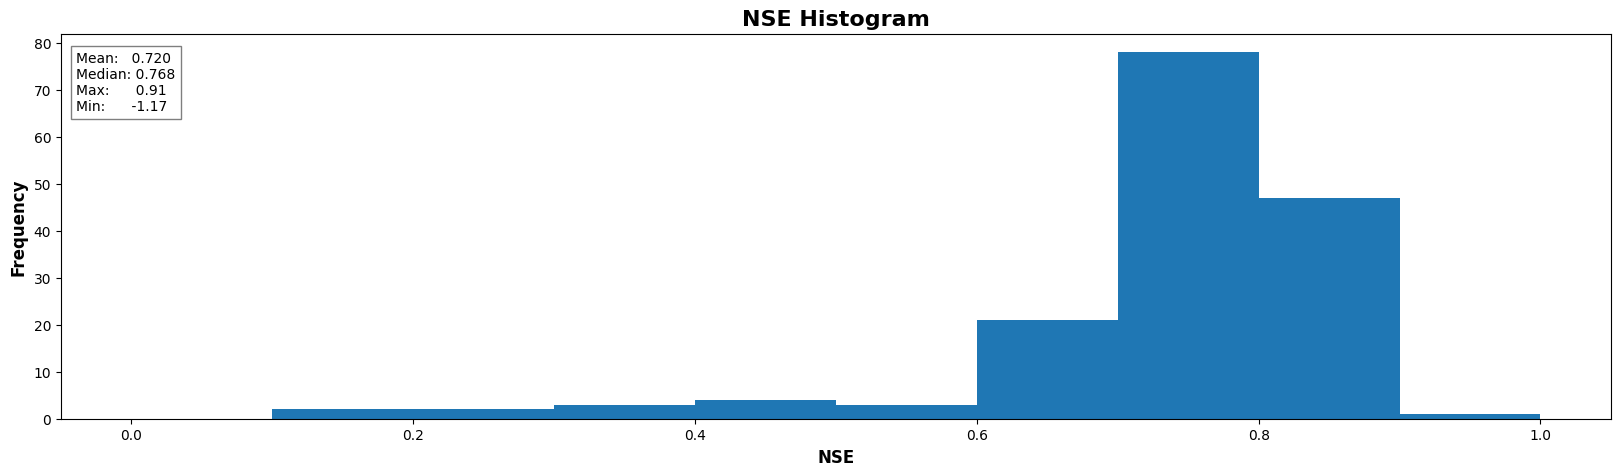

In [33]:
# Plot the histogram
plt.hist(df_NSE["NSE"], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.3f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.3f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor="white", alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel("NSE", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.title("NSE Histogram", fontsize=16, fontweight="bold")
#plt.savefig(save_folder+"/NSE_LSTM_Histogram.png", bbox_inches="tight", pad_inches=0)
plt.show()

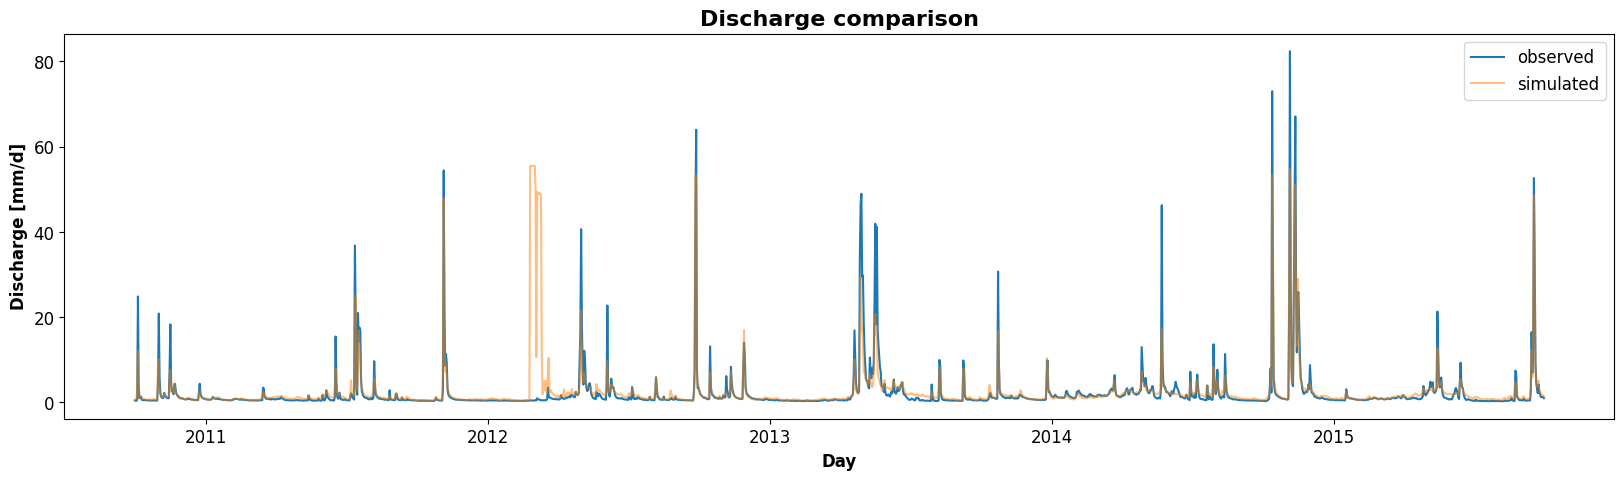

In [34]:
# Plot simulated and observed discharges
basin_to_analyze = "2368"

plt.plot(inspect_results[basin_to_analyze]["y_obs"], label="observed", color=color_palette["observed"])
plt.plot(inspect_results[basin_to_analyze]["y_sim"], label="simulated", alpha=0.5, color=color_palette["simulated"])

# Format plot
plt.xlabel("Day", fontsize=12, fontweight="bold")
plt.ylabel("Discharge [mm/d]", fontsize=12, fontweight="bold")
plt.title("Discharge comparison", fontsize=16, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend(loc="upper right",fontsize=12)
plt.show()
#plt.savefig(save_folder+"/Model_Comparison.png", bbox_inches="tight", pad_inches=0)

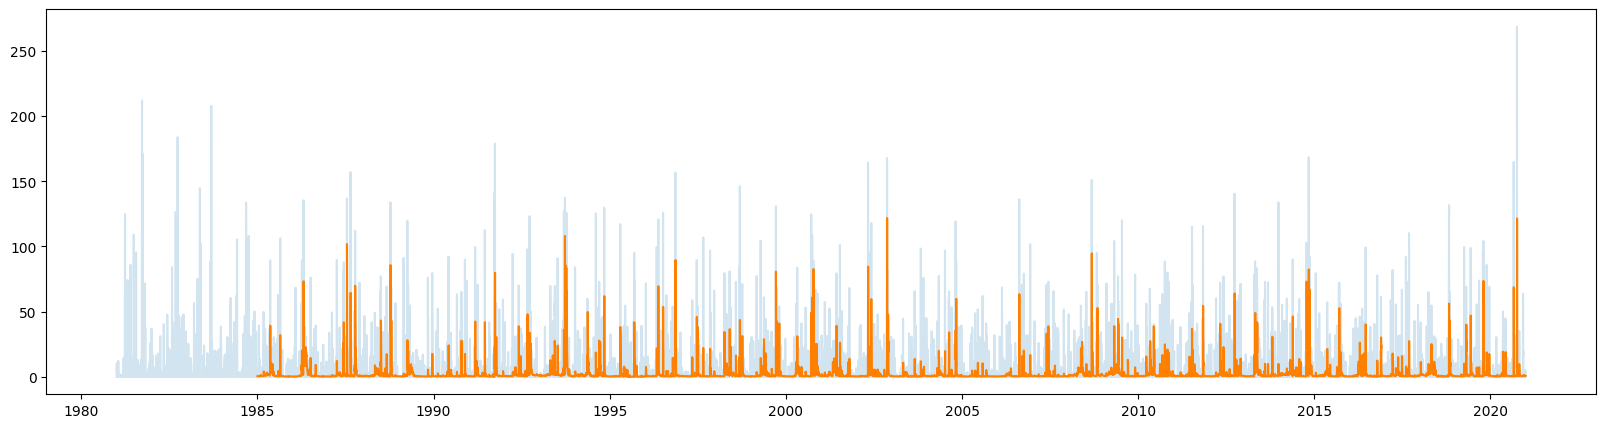

In [35]:
from pathlib import Path
path_timeseries_obs = Path(path_data) / 'timeseries' / 'observation_based' / f'CAMELS_CH_obs_based_{basin_to_analyze}.csv'
# load time series
df_obs = pd.read_csv(path_timeseries_obs)
df_obs = df_obs.set_index('date')
df_obs.index = pd.to_datetime(df_obs.index, format="%Y-%m-%d")

plt.plot(df_obs["precipitation(mm/d)"], label="precipitation", alpha=0.2, color=color_palette["observed"])
plt.plot(df_obs["discharge_spec(mm/d)"], label="discharge", color=color_palette["simulated"])
plt.show()

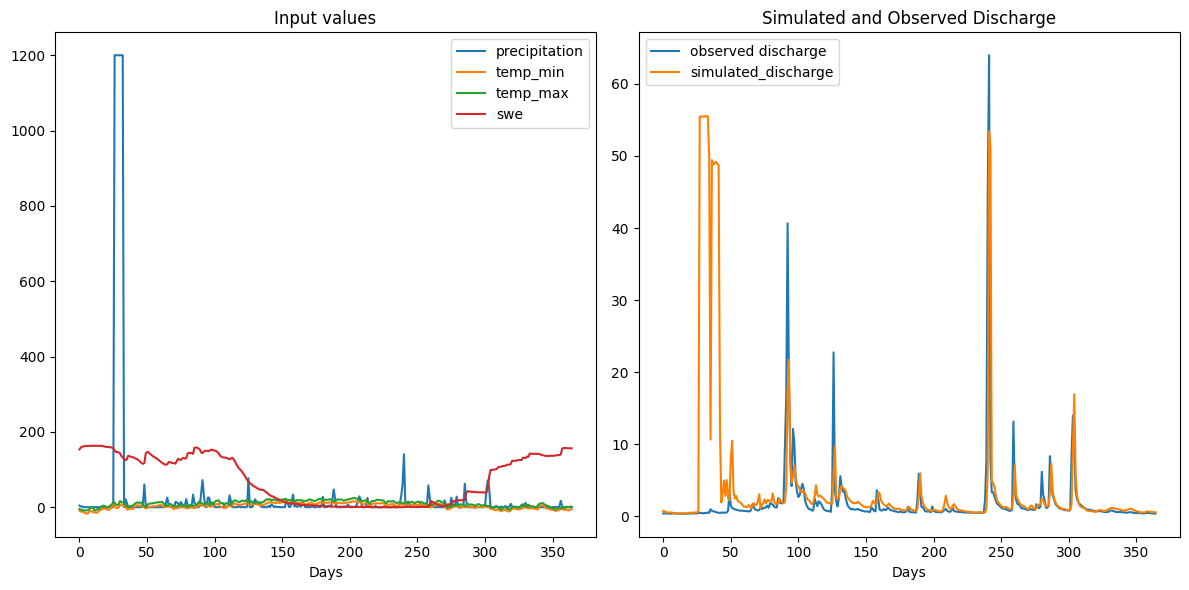

In [38]:
inspectmodel_states = inspect_results_states[basin_to_analyze]
dataset_to_analyze = testing_dataset[basin_to_analyze]

f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
idx = 850
sl = model_hyper_parameters["seq_length"]

# observed input feature values
ax[0].set_title('Input values')
x_d_ = dataset_to_analyze.sequence_data[basin_to_analyze]['x_d'][:, 0:5]*dataset_to_analyze.scaler['x_d_std']+dataset_to_analyze.scaler['x_d_mean']
ax[0].plot(x_d_[idx:idx+sl, 0], label='precipitation')  
ax[0].plot(x_d_[idx:idx+sl, 1], label='temp_min')  
ax[0].plot(x_d_[idx:idx+sl, 2], label='temp_max')  
# ax[0,0].plot(x_d_[idx:idx+sl, 3], label='sun_dur')  
ax[0].plot(x_d_[idx:idx+sl, 4], label='swe')  
ax[0].legend()
ax[0].set_xlabel('Days')

ax[1].set_title('Simulated and Observed Discharge')
y_obs = dataset_to_analyze.sequence_data[basin_to_analyze]['y_obs'][:]
ax[1].plot(y_obs[idx:idx+sl], label='observed discharge', color=color_palette["observed"])
ax[1].plot(inspectmodel_states[0]['y_sim'][idx-sl:idx].numpy(), label='simulated_discharge', color=color_palette["simulated"])
ax[1].legend()
ax[1].set_xlabel('Days')

plt.tight_layout()
plt.savefig(path_save_folder+'/Transformer_saturation.png', bbox_inches='tight', pad_inches=0.2)